In [2]:
import os
import glob
import time
import json
import numpy as np
import pandas as pd
import pickle
from multiprocessing.pool import Pool
from collections import defaultdict
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from scipy.sparse import csr_matrix
from scipy.interpolate import NearestNDInterpolator
from scipy.spatial import Voronoi, distance_matrix
import matplotlib as mpl
import matplotlib.cm as cm
import cv2
import cc3d
from skimage.morphology import ball as morphology_ball
from skimage.morphology import cube as morphology_cube
from skimage.filters.rank import median as rank_median_filter
from sklearn.metrics.pairwise import euclidean_distances

import leidenalg as lg
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree, BallTree

import sys
sys.path.append("/Users/krystal/Desktop/project/pylib-main")
from anatomy.anatomy_config import MASK_CCF25_FILE, MASK_CCF25_R314_FILE, REGION314, REGION671, SALIENT_REGIONS
from image_utils import get_mip_image, image_histeq
from file_io import load_image, save_image
from anatomy.anatomy_vis import detect_edges2d,get_brain_mask2d,get_section_boundary,get_brain_outline2d
from math_utils import min_distances_between_two_sets
from generate_me_map import process_mip

sys.path.append('/Users/krystal/Desktop/project/Brain_test/BrainParcellation/common_lib')
from configs import __FEAT_NAMES__, __FEAT_ALL__

#### Microenvironment Radius

In [2]:
feature_file = '/Users/krystal/Desktop/project/microenvironment/lm_features_d28.csv'
filter_file = '/Users/krystal/Desktop/project/Brain_test/BrainParcellation/evaluation/data/final_filtered_swc.txt'

In [4]:
def get_highquality_subset(feature_file, filter_file):
    df = pd.read_csv(feature_file, index_col=0)
    print(f'Initial number of recons: {df.shape[0]}')
    fl = pd.read_csv(filter_file, names=['Name'])
    #names = [n[:-9] for n in fl.Name]
    names = fl.Name
    df = df[df.index.isin(names)]
    print(f'Number of filtered recons: {df.shape[0]}')

    assert df.isna().sum().sum() == 0
    return df
def estimate_radius(lmf, topk=5, percentile=50):
    spos = lmf[['soma_x', 'soma_y', 'soma_z']]
    print(len(spos))
    topk_d = min_distances_between_two_sets(spos, spos, topk=topk+1, reciprocal=False)
    topk_d = topk_d[:,-1]
    pp = [0, 25, 50, 75, 100]
    pcts = np.percentile(topk_d, pp)
    print(f'top{topk} threshold percentile: {pcts}')
    pct = np.percentile(topk_d, percentile)
    print(f'Selected threshold by percentile[{percentile}] = {pct:.2f} um')
    
    return pct

In [5]:
df = get_highquality_subset(feature_file, filter_file)

Initial number of recons: 179568
Number of filtered recons: 103603


In [6]:
pct = estimate_radius(df, topk=5, percentile=75)

103603
top5 threshold percentile: [ 28.34184539  96.09741802 124.43509192 166.34171835 773.71830979]
Selected threshold by percentile[75] = 166.34 um


In [7]:
spos = df[['soma_x', 'soma_y', 'soma_z']]
print(len(spos))
topk_d = min_distances_between_two_sets(spos, spos, topk=5+1, reciprocal=False)
topk_d = topk_d[:,-1]
pp = [0, 25, 50, 75, 100]
pcts = np.percentile(topk_d, pp)
print(f'top{5} threshold percentile: {pcts}')
pct = np.percentile(topk_d, 75)
print(f'Selected threshold by percentile[{75}] = {pct:.2f} um')

103603
top5 threshold percentile: [ 28.34184539  96.09741802 124.43509192 166.34171835 773.71830979]
Selected threshold by percentile[75] = 166.34 um


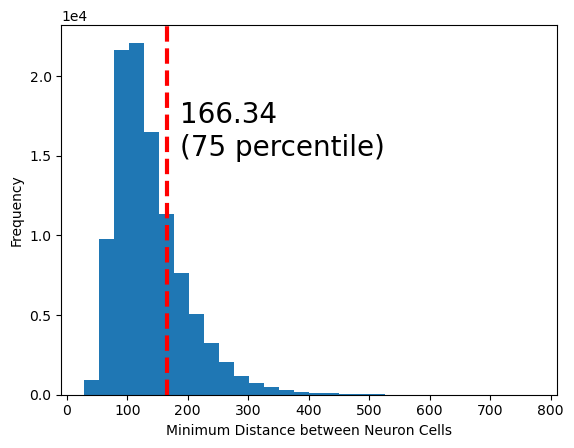

In [9]:
percentiles = np.percentile(topk_d, 75)
plt.hist(topk_d, bins=30)
plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
 
# 添加百分位数标签
#for percentile in percentiles:
plt.axvline(percentiles, color='r', linestyle='dashed', linewidth=3)
plt.text(x=percentiles+20,y=15000,s='166.34\n(75 percentile)',fontsize=20)
 
# 设置x和y轴的标签
plt.xlabel('Minimum Distance between Neuron Cells')
plt.ylabel('Frequency')

plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/dist_percentile.png",dpi=100)

#### 5 neurons(example selected)

In [25]:
df[(df['region_name_r316']=='MOB')&(df['Nodes']>500)]

,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,OverallHeight,OverallDepth,AverageDiameter,...,soma_x,soma_y,soma_z,region_id_r316,pc11,pc12,pc13,pca_vr1,pca_vr2,pca_vr3
17015_7190_2139,704,3216.9900,0.337563,1.092357,1.076359,1.062628,1.212778,1.320377,0.836270,6.73352,...,2375.180,3973.57,6424.43,507,0.123117,1.465658,-0.507635,-0.622151,0.081656,0.920361
17314_11015_1966,702,5026.5500,1.338980,0.884121,0.939199,0.995048,1.041213,0.964527,0.900256,8.41538,...,2314.450,5547.82,6340.27,507,-0.228163,-1.339607,0.955118,-0.735545,0.028982,1.160233
18215_7551_2066,857,4536.4600,1.338980,1.786479,1.796447,1.806013,0.587692,0.946471,1.215070,10.69730,...,2207.280,4148.80,6042.73,507,-0.471808,-1.447327,-0.484701,-1.939364,0.654834,2.441575
24129_6028_2125,818,4071.5000,0.337563,1.508830,1.522128,1.535691,-0.114036,1.292541,1.470376,5.39927,...,1872.970,3548.47,4042.55,507,0.075450,1.357056,-0.854612,-0.969219,0.736515,0.783261
20825_21159_1145,793,4536.4600,-0.663855,1.717067,1.659288,1.603272,-1.291083,-1.112644,1.435823,3.23127,...,1391.850,5139.45,7080.38,507,0.198329,0.139701,1.888285,1.993652,-1.981662,-1.112935
10204_16742_1811,809,6647.6100,2.340397,1.370006,1.419258,1.468111,-0.301070,1.077376,1.142765,8.12138,...,2036.120,3344.47,4982.40,507,0.016643,1.493964,-0.357827,-0.765297,0.166588,1.061502
11909_24148_1472,550,2123.7200,1.338980,0.189999,0.253400,0.319244,-0.624511,1.281256,0.153534,6.54509,...,1622.200,4280.73,7374.43,507,0.261199,-1.562165,-0.124969,0.482732,-0.672650,-0.063618
12507_22945_1387,645,4071.5000,0.337563,0.398235,0.424850,0.454405,0.096201,1.169160,0.816434,8.46450,...,1517.030,4480.55,6928.15,507,0.575419,-1.374048,0.774816,-1.068560,1.528248,0.098876
13024_23330_1622,1542,5026.5500,2.340397,4.354730,4.402483,4.441650,1.064417,1.307587,1.119730,4.21025,...,1848.880,4656.85,7029.18,507,-0.331236,1.025007,-1.328965,-1.417806,0.059490,2.232546
13926_22751_1490,680,4536.4600,0.337563,0.884121,0.870619,0.859887,0.836601,0.999886,1.138926,10.36880,...,1677.650,5007.12,6795.32,507,-0.964837,0.924454,-1.029668,-1.257715,0.613686,1.381611


In [37]:
df_mef = df.copy()
feat_names = __FEAT_NAMES__ + ['pc11', 'pc12', 'pc13', 'pca_vr1', 'pca_vr2', 'pca_vr3']
mefeat_names = [f'{fn}_me' for fn in feat_names]

df_mef[mefeat_names] = 0.

# we should pre-normalize each feature for topk extraction
feats = df.loc[:, feat_names]
feats = (feats - feats.mean()) / (feats.std() + 1e-10)
df[feat_names] = feats

spos = df[['soma_x', 'soma_y', 'soma_z']]
print(f'--> Extracting the neurons within radius for each neuron')
# using kdtree to find out neurons within radius
spos_kdt = KDTree(spos, leaf_size=2)
radius = pct
in_radius_neurons = spos_kdt.query_radius(spos, radius, return_distance=True)

# iterate over all samples
t0 = time.time()
for i, indices, dists in zip(range(spos.shape[0]), *in_radius_neurons):
    # if df['region_name_r316'].iloc[i] != 'AOB':
    #     continue
    if i != 16558:
        continue
    f0 = feats.iloc[i]  # feature for current neuron
    fir = feats.iloc[indices]   # features for in-range neurons
    fdists = np.linalg.norm(f0 - fir, axis=1)
    # select the topK most similar neurons for feature aggregation
    k = min(5, fir.shape[0]-1)
    # if k < 5:
    #     continue
    idx_topk = np.argpartition(fdists, k)[:k+1]
    # map to the original index space
    topk_indices = indices[idx_topk]
    print(i)
    print(topk_indices)
    topk_dists = dists[idx_topk]

    # get the average features
    swc = df_mef.index[i]
    # spatial-tuned features
    dweights = np.exp(-topk_dists/radius)
    dweights /= dweights.sum()
    values = df.iloc[topk_indices][feat_names] * dweights.reshape(-1,1)

    if len(topk_indices) == 1:
        df_mef.loc[swc, mefeat_names] = values.to_numpy()[0]
    else:
        df_mef.loc[swc, mefeat_names] = values.sum().to_numpy()

    if i % 1000 == 0:
        print(f'[{i}]: time used: {time.time()-t0:.2f} seconds')
    
    break

--> Extracting the neurons within radius for each neuron
16558
[ 16559  16558  16551  16552  82130 100664]


In [36]:
np.where(np.array(df.index)=="17365_16267_1526")

(array([16558]),)

In [38]:
eg_topid = [16559,16558,16551,16552,82130,100664]
df.iloc[eg_topid]

,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,OverallHeight,OverallDepth,AverageDiameter,...,soma_x,soma_y,soma_z,region_id_r316,pc11,pc12,pc13,pca_vr1,pca_vr2,pca_vr3
17397_16311_1521,461,1017.880,-0.663855,0.537060,0.493430,0.454405,-0.694122,-0.417495,0.446592,8.64121,...,1484.72,5266.52,4331.95,507,-0.935710,0.122315,1.569192,0.638752,-0.398261,-0.609239
17365_16267_1526,784,2463.010,0.337563,1.786479,1.796447,1.806013,-0.308101,0.342354,0.924571,8.45816,...,1495.20,5249.20,4318.18,507,-0.693484,0.551065,1.571189,0.135551,0.322796,-0.564142
17018_16183_1506,332,2827.430,0.337563,-0.226474,-0.192369,-0.153819,0.262844,0.473258,1.014152,8.73072,...,1479.80,5120.98,4313.90,507,-0.707703,0.540323,1.569342,0.568475,-0.313682,-0.585721
17118_16473_1557,688,2123.720,-0.663855,0.814709,0.836329,0.859887,0.300813,0.757637,0.914973,7.81948,...,1534.45,5175.07,4431.85,507,0.608169,-0.823884,-1.529702,-0.767035,0.223818,1.003217
11461_10973_1769,228,314.159,-0.663855,-0.642947,-0.672429,-0.694463,-0.056379,-1.673885,0.749248,3.52895,...,1452.70,5248.57,4242.00,507,1.668342,0.629853,-0.419210,0.080291,0.838743,-1.025495
10164_13018_1326,222,804.248,0.337563,-0.573535,-0.569559,-0.559302,-1.019673,-0.942619,0.243755,4.32973,...,1489.22,5138.93,4228.50,507,1.456419,0.100022,1.224203,-0.679941,-0.113336,1.222128


#### Feature Strengthening Test

/var/folders/7l/zhd6m6dn33s94rgr0gyffgq40000gn/T/ipykernel_3654/1910077248.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','0.153','0.305'])


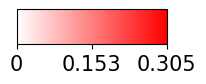

In [22]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
fig = plt.figure(figsize=(1.5,0.7),dpi=100)
ax = fig.add_axes([0,0,1,0.5])
cmap_data = [(0.0,'white'),(1.0,'red')]
new_cmap = LinearSegmentedColormap.from_list('my_color',cmap_data,N=256)
norm = mpl.colors.Normalize(vmin=0,vmax=40)
im =mpl.cm.ScalarMappable(norm = norm, cmap=new_cmap)
formater = mpl.ticker.StrMethodFormatter('{x:.1f}')
cbar = fig.colorbar(im, orientation = 'horizontal',cax = ax)
ax.set_xticklabels(['0','0.153','0.305'])
ax.tick_params(labelsize = 15)
plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/scalebar_red.png",dpi=100,bbox_inches = 'tight')

In [15]:
feats = df.loc[:, feat_names]
feats = (feats - feats.mean()) / (feats.std() + 1e-10)
df[feat_names] = feats

In [16]:
feats_corr = feats.corr()

##### original

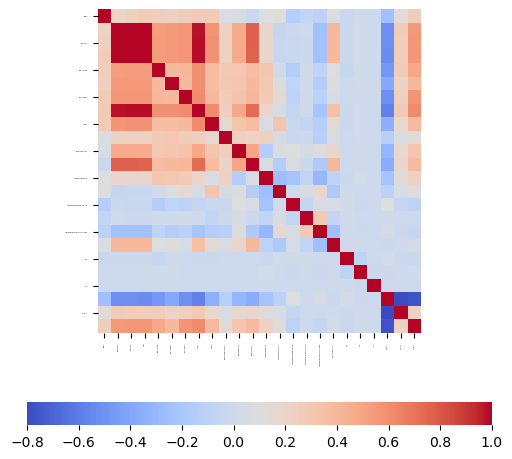

In [34]:
plt.figure(figsize=(6,6),dpi=100)
#sns.heatmap(data = feats_corr,vmin=-0.8,vmax=1.0,square=True,cmap='coolwarm')
sns.heatmap(data = feats_corr,vmin=-0.8,vmax=1.0,square=True,cbar_kws={"orientation":"horizontal"},cmap='coolwarm')
plt.tick_params(labelsize=0)
plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/corr_df_cbar.png",dpi=100)


In [272]:
feature_file_path = '/Users/krystal/Desktop/project/microenvironment/lm_features_d28.csv'
filter_file_path = '/Users/krystal/Desktop/project/microenvironment/final_filtered_swc0207.txt'
df = get_highquality_subset(feature_file_path,filter_file_path)
radius = estimate_radius(df,topk=5,percentile=75)

Initial number of recons: 179568
Number of filtered recons: 103603
top5 threshold percentile: [ 28.34184539  96.09741802 124.43509192 166.34171835 773.71830979]
Selected threshold by percentile[75] = 166.34 um


In [3]:
def load_features(mefile, scale=25., feat_type='full', flipLR=True):
    df = pd.read_csv(mefile, index_col=0, comment='#')
    
    if feat_type == 'full':
        cols = df.columns
        fnames = [fname for fname in cols if fname[-3:] == '_me']
    elif feat_type == 'mRMR':
        # Features selected by mRMR
        fnames = ['Length_me', 'AverageFragmentation_me', 'AverageContraction_me']
    elif feat_type == 'PCA':
        fnames = ['pca_feat1', 'pca_feat2', 'pca_feat3']
    else:
        raise ValueError("Unsupported feature types")

    # standardize
    tmp = df[fnames]
    tmp = (tmp - tmp.mean()) / (tmp.std() + 1e-10)
    df[fnames] = tmp

    # scaling the coordinates to CCFv3-25um space
    df['soma_x'] /= scale
    df['soma_y'] /= scale
    df['soma_z'] /= scale
    # we should remove the out-of-region coordinates
    zdim,ydim,xdim = (456,320,528)   # dimensions for CCFv3-25um atlas
    in_region = (df['soma_x'] >= 0) & (df['soma_x'] < xdim) & \
                (df['soma_y'] >= 0) & (df['soma_y'] < ydim) & \
                (df['soma_z'] >= 0) & (df['soma_z'] < zdim)
    df = df[in_region]
    print(f'Filtered out {in_region.shape[0] - df.shape[0]}')

    if flipLR:
        # mirror right hemispheric points to left hemisphere
        zdim2 = zdim // 2
        nzi = np.nonzero(df['soma_z'] < zdim2)
        loci = df.index[nzi]
        df.loc[loci, 'soma_z'] = zdim - df.loc[loci, 'soma_z']

    return df, fnames

In [4]:
mefile = '/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/data/mefeatures_100K_with_PCAfeatures3.csv'
df,fnames = load_features(mefile, scale=25)

Filtered out 0


In [60]:
df_mef_only = df[df.columns[34:58]]

##### microenvironmental

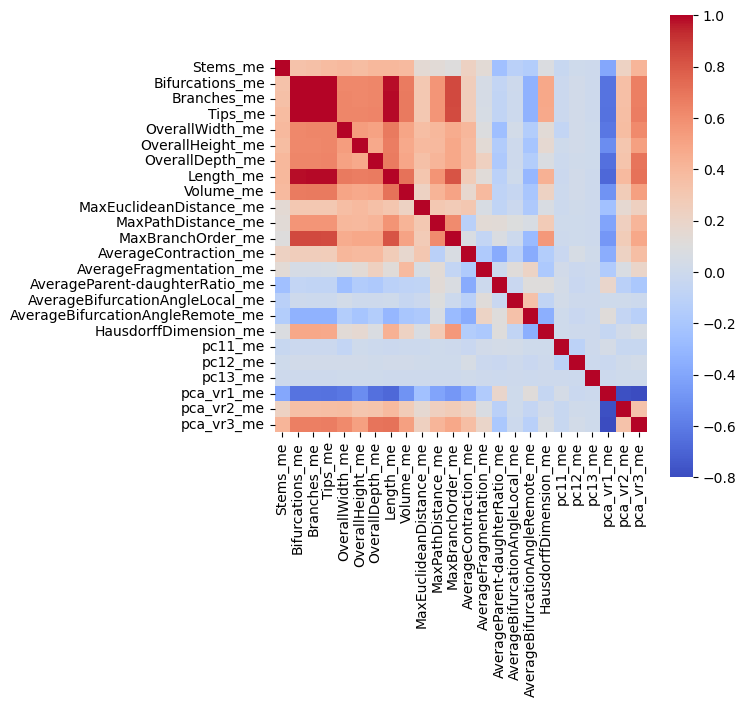

In [40]:
plt.figure(figsize=(6,6),dpi=100)
df_mef_only_corr = df_mef_only.corr()
sns.heatmap(df_mef_only_corr,vmin=-0.8,vmax=1.0,square=True,cmap='coolwarm')
plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/corr_mef.png",dpi=100)

#### Feature Differentiation (shown by sihouette score)

In [5]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [6]:
F_namelist = list(df.columns[2:9])+list(df.columns[10:11])+list(df.columns[12:22])+list(df.columns[28:34])
K = range(2,10)
score1 = []
score2 = []
for r in SALIENT_REGIONS:
    df_r = df[df['region_id_r671']==r]
    if len(df_r) < 50:
        continue
    df_r_org = df_r[F_namelist]
    df_org_n = (df_r_org - df_r_org.mean()) / (df_r_org.std() + 1e-10)
    r_mef = df_r[df_r.columns[34:58]]
    s1 = []
    s2 = []
    for k in K:
        kmeans1 = KMeans(n_clusters=k)
        kmeans1.fit(df_org_n)
        s1.append(silhouette_score(df_org_n,kmeans1.labels_,metric = 'euclidean'))
        kmeans2 = KMeans(n_clusters=k)
        kmeans2.fit(r_mef)
        s2.append(silhouette_score(r_mef,kmeans2.labels_,metric = 'euclidean'))
    score1.append(s1)
    score2.append(s2)
score1 = np.array(score1)
score2 = np.array(score2)

In [7]:
score1.shape,score2.shape

((218, 8), (218, 8))

In [8]:
score1_mean = np.mean(score1,axis=0)
score2_mean = np.mean(score2,axis=0)
score1_std = np.std(score1, axis=0)
score2_std = np.std(score2, axis=0)

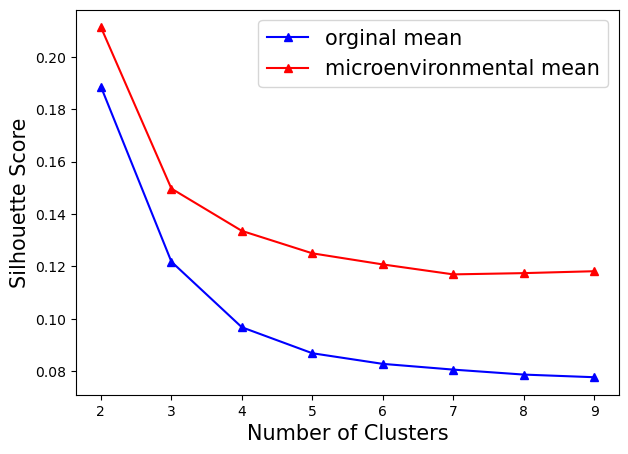

In [9]:
fig = plt.figure(figsize=(7,5))
plt.plot(K,score1_mean,marker='^',color='b',label = 'orginal mean')
plt.plot(K,score2_mean,marker='^',color='r',label='microenvironmental mean')
# plt.plot(K,score1_std,marker='*',color='b',label = 'orignal std',linestyle = ':')
# plt.plot(K,score2_std,marker='*',color='r',label='microenvironmental std',linestyle=':')
plt.xlabel("Number of Clusters",fontsize = 15)
plt.ylabel("Silhouette Score",fontsize=15)
#plt.title("Silhouette Score for MOB:\nComparison between original and microenvironmental feature matrix",fontsize=15)
plt.legend(fontsize=15)
plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/corr_mef.png",dpi=100,bbox_inches = 'tight')

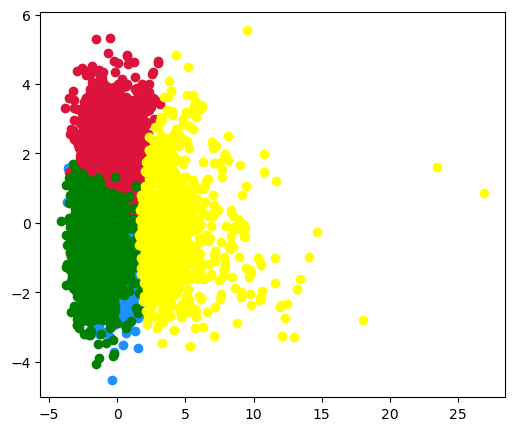

In [71]:
from sklearn.decomposition import PCA
n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster)
l1 = kmeans.fit_predict(vpm_Forg_n)
pca = PCA(n_components=2)
Forg_pca = pca.fit_transform(vpm_Forg_n)

fig = plt.figure(figsize=(6,5))
colors = ['dodgerblue','crimson','green','yellow','pink']
for i in range(0,np.max(l1)+1):
    plt.scatter(Forg_pca[l1==i,0],Forg_pca[l1==i,1],c = colors[i])

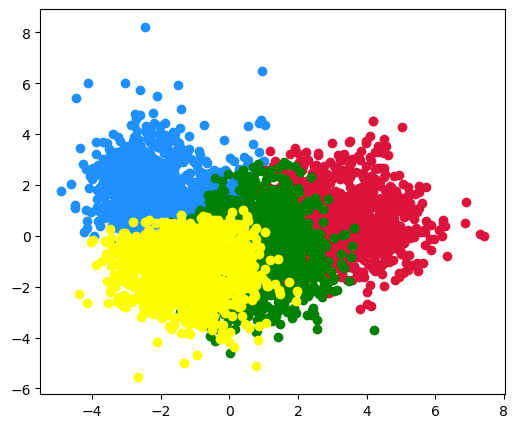

In [73]:
kmeans = KMeans(n_clusters=n_cluster)
l2 = kmeans.fit_predict(vpm_mef)
pca = PCA(n_components=2)
mef_pca = pca.fit_transform(vpm_mef)

fig = plt.figure(figsize=(6,5))
for i in range(0,np.max(l2)+1):
    plt.scatter(mef_pca[l2==i,0],mef_pca[l2==i,1],c = colors[i])

#### Clustering Process Shown （step by step）

In [3]:
## 919 example
eg_file_path = "/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/Tmp/parc_region919.nrrd"
eg_img = load_image(eg_file_path)

In [4]:
nzcoords = eg_img.nonzero()
nzcoords_t = np.array(nzcoords).transpose()
colorize_eg = random_colorize(nzcoords_t,eg_img[nzcoords],eg_img.shape,np.max(eg_img))

In [8]:
min_pts_per_parc = 8**3

cp_mask = df['region_id_r671'] == 919
coords_all = df[['soma_x', 'soma_y', 'soma_z']]
coords = coords_all[cp_mask]
feats_all = df[fnames].to_numpy()
feats = feats_all[cp_mask]

radius_th = 4.  # 4x25=100um
par2 = 3.

coords = coords.values.astype(np.float64)
n_neighbors = min(150, coords.shape[0])

In [66]:
df[df['region_name_r671'].astype('str').str.contains('MOB')]

,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,OverallHeight,OverallDepth,AverageDiameter,...,pc12_me,pc13_me,pca_vr1_me,pca_vr2_me,pca_vr3_me,pca_feat1,pca_feat2,pca_feat3,region_name_r671,region_id_r671
12246_16455_1190,181,3216.99,2,8,16,9,91.1749,130.150,175.8000,7.81547,...,-0.380093,-1.194071,2.118195,-2.651819,-0.952075,-3.802709,0.267327,-0.905083,MOB,507
13795_9975_1062,150,1256.64,2,5,11,7,96.3750,103.325,158.8250,7.29600,...,0.482476,1.234894,1.564736,-2.091606,-0.590020,-4.011316,0.964539,0.035282,MOB,507
17428_25882_508,218,2463.01,2,9,18,10,130.4000,110.175,139.6750,4.23211,...,0.291879,0.866981,0.338005,-0.274371,-0.278961,-3.360751,-1.155086,1.331276,MOB,507
22286_26409_745,212,6647.61,4,7,16,10,163.0250,145.375,114.5250,11.51420,...,1.236848,1.104133,0.585087,0.337334,-1.176417,-2.155769,-0.882558,2.007806,MOB,507
23251_22544_566,256,4071.50,2,9,18,10,157.6000,107.300,138.0260,8.60000,...,-0.094068,-2.402511,-1.465435,0.427417,1.860169,-0.965475,-1.554195,3.994905,MOB,507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17868_11047_1441,119,1256.64,2,10,20,11,172.8000,117.325,140.7000,5.16134,...,0.771950,1.368064,1.310975,-1.597516,-0.626595,-3.832857,0.197347,1.648816,MOB,507
18164_10131_1540,315,1520.53,4,22,46,25,163.8000,184.600,80.3501,3.65460,...,-0.039620,-0.651615,1.579827,-1.957155,-0.727721,-1.404284,1.925730,0.292409,MOB,507
18199_10257_1477,225,1520.53,4,14,30,17,152.2500,188.850,69.6001,3.90667,...,-0.863774,-0.294927,1.282560,-1.120895,-0.990380,-0.962355,2.214163,0.019575,MOB,507
9858_9955_1231,300,1809.56,3,21,43,23,161.6750,171.550,135.0500,4.47733,...,0.849310,0.396103,0.817180,-1.014547,-0.374540,-2.444711,2.205724,1.115806,MOB,507


In [9]:
A = kneighbors_graph(coords, 
                        n_neighbors=n_neighbors, include_self=True, 
                        mode='distance', metric='euclidean', n_jobs=2)
dist_th = A[A>0].max()# + 1e-5   # to ensure all included

#A = radius_neighbors_graph(coords, radius=dist_th, include_self=True, mode='distance', metric='euclidean', n_jobs=n_jobs)
A.setdiag(0)

A_csr = csr_matrix(A)
sources, targets = A_csr.nonzero()
# estimate the edge weights
dists = A_csr[sources, targets]

In [10]:
wd = np.squeeze(np.asarray(np.exp(-dists/dist_th)))
print(f'wd[mean/max/min]: {wd.mean():.2f}, {wd.max():.2f}, {wd.min():.2f}')
print(f'Total and avg number of edges: {wd.shape[0]}, {wd.shape[0]/feats.shape[0]:.2f}')

wd[mean/max/min]: 0.72, 0.99, 0.37
Total and avg number of edges: 650, 25.00


In [11]:
fs = feats[sources]
ft = feats[targets]
par2 = par2 / 3.
wf = np.exp(-par2 * np.linalg.norm(fs - ft, axis=1))
print(f'wf[mean/max/min]: {wf.mean():.2f}, {wf.max():.2f}, {wf.min():.2g}')

wf[mean/max/min]: 0.01, 0.43, 5.3e-08


In [12]:
#weights = wd * wf
weights = wf


g = ig.Graph(list(zip(sources, targets)), directed=False)
g.es['weight'] = weights

### Step 3: Apply the Leiden Algorithm
partition = lg.find_partition(g, lg.ModularityVertexPartition, weights='weight', seed=1024)


community_memberships = np.array([i+1 for i in partition.membership]) # re-indexing starting from 1, to differentiate with background

# denoising at the neuron level
# remove nodes with nearest nodes are not the same class
topk = 5
new_coords = coords
A1 = kneighbors_graph(new_coords, n_neighbors=topk-1, include_self=False, mode='distance', metric='euclidean')
yc, xc = A1.nonzero()
Ab = community_memberships[xc].reshape(-1, topk-1)
Ab = np.hstack((community_memberships.reshape(-1,1), Ab))
community_memberships = np.array([np.bincount(row).argmax() for row in Ab])
community_sizes = np.array([len(community) for community in partition])
comms, counts = np.unique(community_sizes, return_counts=True)
communities = defaultdict(list) # community to node

# Populate the dictionary with node indices grouped by their community
for node_index, community_index in enumerate(community_memberships):
    communities[community_index].append(node_index)

##### Leiden

In [17]:
import networkx as nx

plot_g = g.copy()
# plot_gx = nx.Graph(plot_g.get_edgelist())
# nx.draw(plot_gx, with_labels =False, node_size = 30, width=weights*10)
plot_g.es['width'] = weights*10
plot_g.vs['color'] = 'grey'
plot = ig.plot(plot_g,bbox=(300,300),margin=20)
plot.save("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/g.png")

In [95]:
color_dict = {0:"crimson",1:"dodgerblue",2:"limegreen",3:"yellow"}

plot_g.vs["color"] = [color_dict[i] for i in partition.membership]
#plot_g.es['width'] = weights*10
plot = ig.plot(plot_g,bbox=(300,300),margin=20)
plot.save("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/g_cluster.png")

In [14]:
communities, comms = communities, np.array(community_memberships)
mcoords = []    # weighted center of filtered communities
mnodes = []     # filtered nodes
mcomms = []     # community index for each node
coords = coords_all[cp_mask]
feats = feats_all[cp_mask]
for icomm, inodes in communities.items():
    #if len(inodes) < min_pts_per_comm:
    #    continue
    cur_coords = coords.iloc[inodes]
    mnodes.extend(inodes)
    mcomms.extend([icomm]*len(inodes))
    mcoord = cur_coords.mean(axis=0).values
    mcoords.append(mcoord)
mcoords = np.array(mcoords)


In [15]:
mask_file = MASK_CCF25_FILE
mask = load_image(mask_file)  # z,y,x order!
lmask = mask.copy() # left mask
lmask[:mask.shape[0]//2] = 0
reg_mask = lmask == 919
nzcoords = reg_mask.nonzero()
nzcoords_t = np.array(nzcoords).transpose()
zmin, ymin, xmin = nzcoords_t.min(axis=0)
zmax, ymax, xmax = nzcoords_t.max(axis=0)
interp = NearestNDInterpolator(coords.iloc[mnodes][['soma_z', 'soma_y', 'soma_x']].values, mcomms)
predv = interp(*nzcoords)
cur_mask = reg_mask.astype(np.uint16)
cur_mask[nzcoords] = predv

sub_mask = cur_mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]

In [26]:
target_mask =ccf_mask == 919

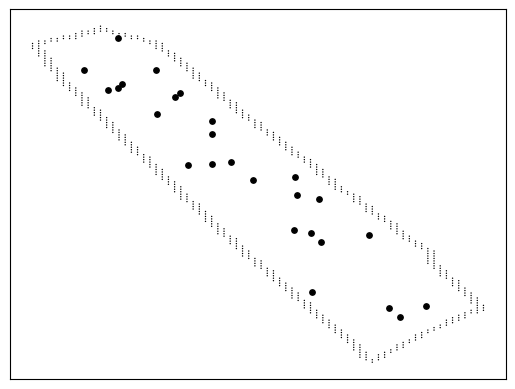

In [42]:
outline_mask2d1 = get_brain_outline2d(target_mask, axis=0, v=1)
o_indices1 = np.where(outline_mask2d1)
eg_df = df[df['region_id_r671']==919]
X = eg_df['soma_x']
Y = eg_df['soma_y']
Z = eg_df['soma_z']
plt.scatter(o_indices1[0], o_indices1[1], s=1, c='black', alpha=1.0, edgecolors='none')
plt.scatter(Y,X,c='black',s=15)
plt.xticks([])
plt.yticks([])
plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/919_pts.png",dpi=100)

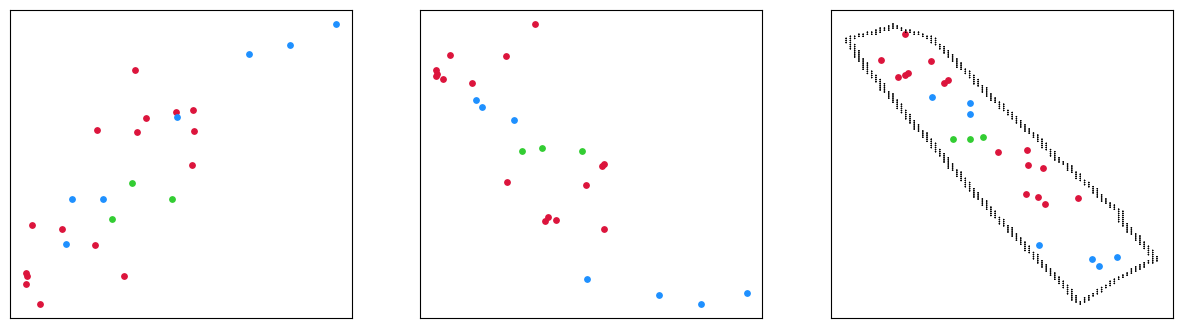

In [198]:
import mpl_toolkits.mplot3d

fig = plt.figure(figsize=(15,4))

outline_mask2d1 = get_brain_outline2d(target_mask, axis=0, v=1)
o_indices1 = np.where(outline_mask2d1)

# ax = plt.subplot(111,projection='3d')
colorlist=['grey','crimson','dodgerblue','limegreen']
X=coords.iloc[mnodes]['soma_z']
Y=coords.iloc[mnodes]['soma_y']
Z=coords.iloc[mnodes]['soma_x']

ax = plt.subplot(131)
co=1
for i in np.unique(mcomms):
    ax.scatter(X[mcomms==i],Y[mcomms==i],c=colorlist[co],s=15)
    co+=1
    plt.xticks([])
    plt.yticks([])

ax = plt.subplot(132)
co=1
for i in np.unique(mcomms):
    ax.scatter(X[mcomms==i],Z[mcomms==i],c=colorlist[co],s=15)
    co+=1
    plt.xticks([])
    plt.yticks([])

ax = plt.subplot(133)
co=1
for i in np.unique(mcomms):
    ax.scatter(o_indices1[0], o_indices1[1], s=1, c='black', alpha=1.0, edgecolors='none')
    ax.scatter(Y[mcomms==i],Z[mcomms==i],c=colorlist[co],s=15)
    co+=1
    plt.xticks([])
    plt.yticks([])

plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/scatter.png",dpi=100)

In [16]:
points = []
predv2 = []
for i in range(sub_mask.shape[0]):
    for j in range(sub_mask.shape[1]):
        for k in range(sub_mask.shape[2]):
            if sub_mask[i,j,k] > 0:
                points.append(np.array([k+xmin,j+ymin,i+zmin]))
                predv2.append(sub_mask[i,j,k])
points = np.array(points)
predv2 = np.array(predv2)

In [23]:
tmp_out = np.concatenate((points,predv2.reshape(22412,1)),axis=1)
np.savetxt("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/919.txt",tmp_out)

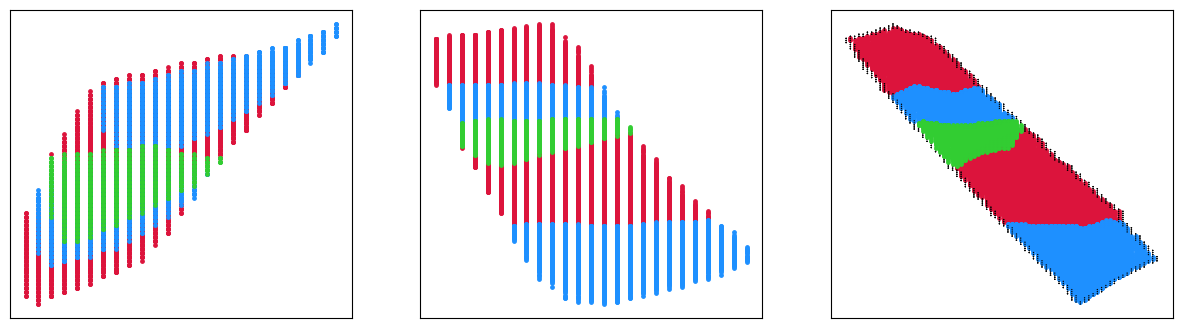

In [197]:
fig = plt.figure(figsize=(15,4))
ax = plt.subplot(131)
co=1
for c in np.unique(mcomms):  
    ax.scatter(points[predv2==c,2],points[predv2==c,1],c=colorlist[co],s=6)
    co+=1
    plt.xticks([])
    plt.yticks([])

ax = plt.subplot(132)
co=1
for c in np.unique(mcomms):  
    ax.scatter(points[predv2==c,2],points[predv2==c,0],c=colorlist[co],s=6)
    co+=1
    plt.xticks([])
    plt.yticks([])

ax = plt.subplot(133)
co=1
for c in np.unique(mcomms):  
    ax.scatter(o_indices1[0], o_indices1[1], s=1, c='black', alpha=1.0, edgecolors='none')
    ax.scatter(points[predv2==c,1],points[predv2==c,0],c=colorlist[co],s=6)
    co+=1
    plt.xticks([])
    plt.yticks([])
    
plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/scatter_interp.png",dpi=100)

In [12]:
def reorder_mask_using_cc(sub_mask, cc_mask, sub_fg_mask, min_pts_per_parc):
    if cc_mask is None:
        cc_mask = cc3d.connected_components(sub_mask, connectivity=26)
        # we would like to re-estimate the small communities/components
        cc_ids, cc_cnts = np.unique(cc_mask, return_counts=True)
    # reordering the mask indices using connected components
    # Firstly, found out the background mask
    bg_ids = np.unique(cc_mask[~sub_fg_mask])
    fg_ids, fg_cnts = np.unique(cc_mask[sub_fg_mask], return_counts=True)
    argsort_ids = np.argsort(fg_cnts)[::-1]
    fg_ids = fg_ids[argsort_ids]
    fg_cnts = fg_cnts[argsort_ids]
    sub_mask[~sub_fg_mask] = 0
    
    # The original CCFv3 atlas does not ensure a connected components
    idict = {}
    cur_id = 0
    for i, fg_id in enumerate(fg_ids):
        cur_fg = cc_mask == fg_id
        sub_id = sub_mask[cur_fg][0]
        if cur_fg.sum() < min_pts_per_parc:
            if sub_id in idict:
                cur_id = idict[sub_id]
            else:
                cur_id += 1
                idict[sub_id] = cur_id
        else:
            cur_id += 1
            if sub_id not in idict:
                idict[sub_id] = cur_id
                
        sub_mask[cur_fg] = cur_id
        #print(cur_fg.sum(), idict)
    #print(np.unique(sub_mask, return_counts=True))
        
def remove_small_parcs(sub_mask, sub_fg_mask, cc_mask=None, cc_ids=None, cc_cnts=None, min_pts=0, use_cc_ids=False):
    if cc_mask is None:
        cc_mask = cc3d.connected_components(sub_mask, connectivity=26)
        # we would like to re-estimate the small communities/components
        cc_ids, cc_cnts = np.unique(cc_mask, return_counts=True)
    
    have_small_parcs = False
    for cc_id, cc_cnt in zip(cc_ids, cc_cnts):
        if cc_cnt < min_pts:
            try:
                interp_mask = interp_mask | (cc_mask == cc_id)
            except UnboundLocalError:
                interp_mask = cc_mask == cc_id
            have_small_parcs = True

    if have_small_parcs:
        if sub_fg_mask.sum() == interp_mask.sum():
            # no sufficient data to interpolate
            sub_mask[sub_fg_mask] = 1
            cc_mask = sub_mask.copy()
            cc_ids, cc_cnts = np.unique(cc_mask, return_counts=True)
            return sub_mask, cc_mask, cc_ids, cc_cnts

        if use_cc_ids:
            reorder_mask_using_cc(sub_mask, cc_mask, sub_fg_mask, min_pts_per_parc)

        anchor_mask = sub_fg_mask ^ interp_mask
        anchor_coords = np.array(np.where(anchor_mask)).transpose()
        anchor_values = sub_mask[anchor_mask]
        interp = NearestNDInterpolator(anchor_coords, anchor_values)
        predv = interp(*np.where(interp_mask))
        sub_mask[interp_mask] = predv

        # re-estimation
        cc_mask = cc3d.connected_components(sub_mask, connectivity=26)
        # we would like to re-estimate the small communities/components
        cc_ids, cc_cnts = np.unique(cc_mask, return_counts=True)

    return sub_mask, cc_mask, cc_ids, cc_cnts

In [13]:
sub_fg_mask = sub_mask > 0
cc_mask, cc_ids, cc_cnts = None, None, None
for i_interp in range(2):
    sub_mask = rank_median_filter(sub_mask, morphology_ball(5), mask=sub_fg_mask)
    sub_mask[~sub_fg_mask] = 0  # force to zero

    if sub_fg_mask.sum() > min_pts_per_parc:
        sub_mask, cc_mask, cc_ids, cc_cnts = remove_small_parcs(sub_mask, sub_fg_mask, cc_mask, cc_ids, cc_cnts, min_pts_per_parc)

niter = 0
while (sub_fg_mask.sum() > min_pts_per_parc) and ((cc_cnts<min_pts_per_parc).sum() > 0):
    if niter < 2:
        sub_mask, cc_mask, cc_ids, cc_cnts = remove_small_parcs(sub_mask, sub_fg_mask, cc_mask, cc_ids, cc_cnts, min_pts_per_parc)
    else:
        #sub_mask, cc_mask, cc_ids, cc_cnts = self.remove_small_parcs(sub_mask, sub_fg_mask, cc_mask, cc_ids, cc_cnts, min_pts_per_parc, use_cc_ids=True)
        break

    niter += 1

reorder_mask_using_cc(sub_mask, cc_mask, sub_fg_mask, min_pts_per_parc)
cur_mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1] = sub_mask

In [2]:
def random_colorize(coords, values, shape3d, color_level):
    """
    coords in shape of [N,3], in order of ZYX
    """
    # map the communities to different colors using randomized color map
    norm = mpl.colors.Normalize(values.min(), vmax=values.max())
    vals = np.linspace(0,1,color_level)
    np.random.shuffle(vals)
    cmap = cm.colors.ListedColormap(cm.jet(vals))
    print(cmap)
    #cmap = cm.bwr
    smapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors = np.floor(smapper.to_rgba(values) * 255).astype(np.uint8)
    zyx = np.floor(coords).astype(np.int32)

    # intialize map
    pmap = np.zeros((*shape3d, colors.shape[-1]), dtype=np.uint8)
    pmap[zyx[:,0], zyx[:,1], zyx[:,2]] = colors

    return pmap

In [15]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [16]:
def plot_section_outline(mask, axis=0, sectionX=None, ax=None, with_outline=True, outline_color='orange', b_scale=0.5):
    boundary_mask2d = get_section_boundary(mask, axis=axis, v=1, c=sectionX)
    sh, sw = boundary_mask2d.shape[:2]
    if ax is None:
        fig, ax = plt.subplots()
        brain_mask2d = get_brain_mask2d(mask, axis=axis, v=1)
        im = np.ones((sh, sw, 4), dtype=np.uint8) * 255
        im[~brain_mask2d] = 0#1

    # show boundary
    b_indices = np.where(boundary_mask2d)
    ax.scatter(b_indices[1], b_indices[0], s=b_scale, c='black', alpha=0.5, edgecolors='none')
    # intra-brain regions
        
    if with_outline:
        outline_mask2d = get_brain_outline2d(mask, axis=axis, v=1)
        o_indices = np.where(outline_mask2d)
        ax.scatter(o_indices[1], o_indices[0], s=1.0, c=outline_color, alpha=1.0, edgecolors='none')
    
    if ax is None:
        return fig, ax
    else:
        return ax
        
def process_mip(mip, mask, sectionX=None, axis=0, figname='temp.png', mode='composite', with_outline=True, outline_color='orange', pt_scale=2, b_scale=0.5):
    # get the mask
    brain_mask2d = get_brain_mask2d(mask, axis=axis, v=1)

    #if axis==1: cv2.imwrite('temp.png', mip); sys.exit()
    im = np.ones((mip.shape[0], mip.shape[1], 4), dtype=np.uint8) * 255
    # default size is 6.4 x 4.8
    scale = np.sqrt(np.prod(mip.shape[:2]) / 456 / 320)
    wi, hi = np.round(6.4 * scale, 2), np.round(4.8 * scale, 2)

    fig, ax = plt.subplots(figsize=(wi, hi))
    width, height = fig.get_size_inches() * fig.get_dpi()
    width = int(width)
    height = int(height)

    canvas = FigureCanvas(fig)
    im = ax.imshow(im)
    fig.patch.set_visible(False)
    ax.axis('off')
    
    bg_mask = mip.sum(axis=-1) == 0
    fg_mask = ~bg_mask
    fg_indices = np.where(fg_mask)
    if mode == 'composite':
        fg_values = mip[fg_indices] / 255.
        cmap = None
    else:
        fg_values = mip[fg_indices][:,0] / 255.
        cmap = 'coolwarm'
    
    if len(fg_indices[0]) > 0:
        ax.scatter(fg_indices[1], fg_indices[0], c=fg_values, s=pt_scale, edgecolors='none', cmap=cmap)
    plot_section_outline(mask, axis=axis, sectionX=sectionX, ax=ax, with_outline=with_outline, outline_color=outline_color, b_scale=b_scale)

    plt.savefig(figname, dpi=300)
    plt.close('all')


In [17]:
def save_colorized_images(cmask, mask, out_image_file):
    zdim, ydim, xdim = mask.shape
    # zdim2, ydim2, xdim2 = zdim // 2, ydim // 2, xdim // 2
    # # visualize
    # prefix = os.path.splitext(os.path.split(out_image_file)[-1])[0]
    #fprefix = os.path.join(self.out_vis_dir, prefix)

    thickX2 = 20
    for i, dim in zip(range(3), (zdim, ydim, xdim)):
        if i != 2: continue

        for isec, sec in enumerate(range(thickX2, dim, thickX2*2)):
            k = sec
            m2d0 = np.take(cmask, k, i)
            # overlay the boundaries
            m2d1 = np.take(mask, k, i)
            edges = detect_edges2d(m2d1)
            p1 = m2d0.copy()
            p1[edges] = np.array([0,0,0,255])
            #outfile = f'{fprefix}_axid{i}_{isec:02d}.png'
            outfile = "/Users/krystal/Desktop/project/microenvironment/figs/Fig3/tmp.png"
            cv2.imwrite(outfile, p1)
            if i != 0:
                #print(f'Rotate by 90 degree')
                os.system(f'convert {outfile} -rotate 90 {outfile}')

    print()

### CP+ ACB

In [10]:
cp_file_path = "/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/Tmp/parc_region672.nrrd"
acb_file_path = "/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/Tmp/parc_region56.nrrd"
cp_parc = load_image(cp_file_path)
acb_parc = load_image(acb_file_path)
np.max(cp_parc), np.max(acb_parc)

(16, 9)

In [11]:
## merge
mask_file = MASK_CCF25_FILE
mask = load_image(mask_file)
str_mask = mask.copy()
str_mask.fill(0)
cur_id = 0
nzm1 = cp_parc != 0
str_mask[nzm1] = cp_parc[nzm1] + cur_id
cur_id += cp_parc.max()
nzm2 = acb_parc != 0
str_mask[nzm2] = cp_parc[nzm2] + cur_id

In [7]:
str_file_path = '/Users/krystal/Desktop/project/Brain_test/BrainParcellation/microenviron/Tmp/parc_region_str.nrrd'
str_mask = load_image(str_file_path)

In [8]:
nzcoords = str_mask.nonzero()
nzcoords_t = np.array(nzcoords).transpose()
colorize_str = random_colorize(nzcoords_t,str_mask[nzcoords],str_mask.shape,np.max(str_mask))

In [9]:
np.max(str_mask)

17

In [18]:
zmin, ymin, xmin = nzcoords_t.min(axis=0)
zmax, ymax, xmax = nzcoords_t.max(axis=0)

In [10]:
slice_num = [152,169,180,195,218,232,247,267] 

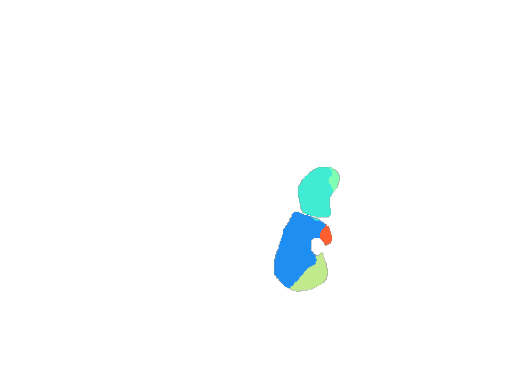

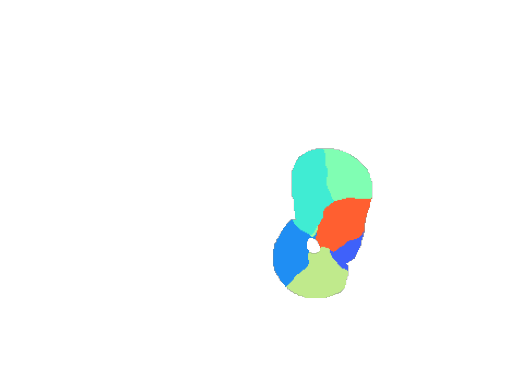

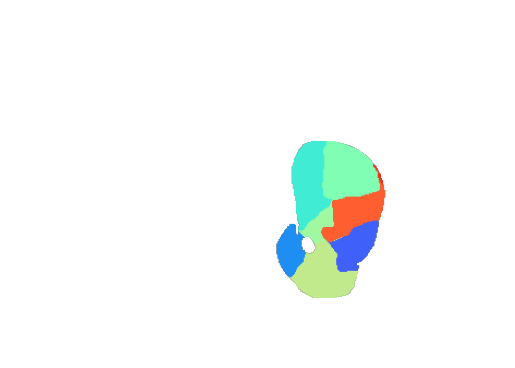

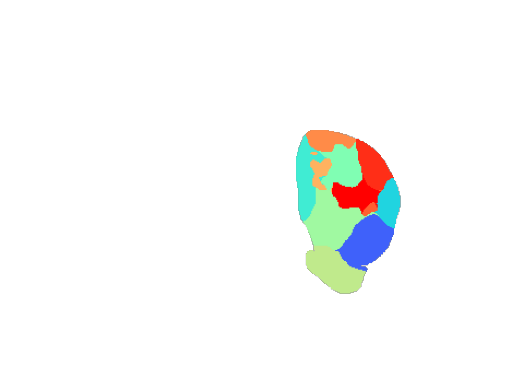

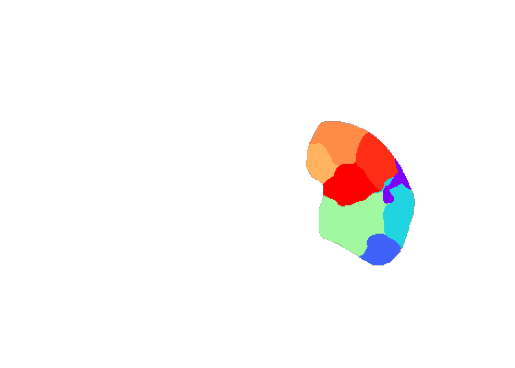

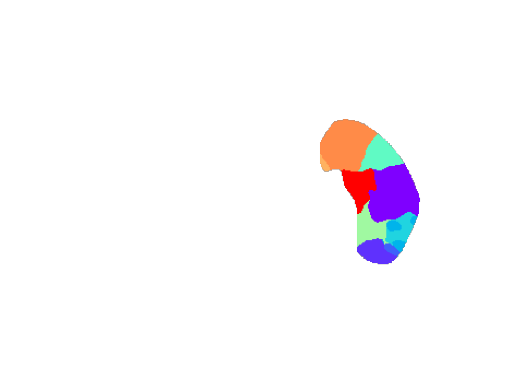

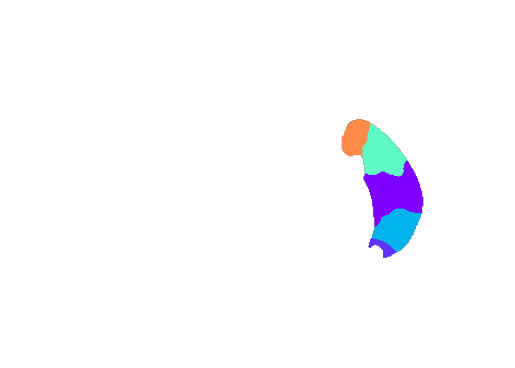

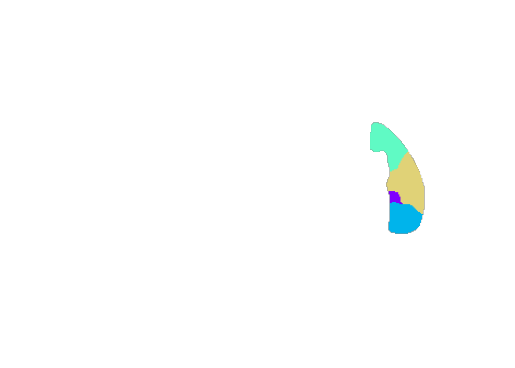

In [11]:
for i in slice_num:
    plt.figure()
    plt.imshow(np.transpose(colorize_str[:,:,int(i)],axes=[1,0,2]))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    out_path = '/Users/krystal/Desktop/project/microenvironment/figs/Fig3/STR/str_'+str(int(i))+'.png'
    plt.savefig(out_path,dpi=100)

In [12]:
template_file = "/Users/krystal/Desktop/project/average_template_25.nrrd.UNIT8.v3draw"
#mask_file = "/Users/krystal/Desktop/project/average_template_25_ARA.nrrd"
template = load_image(template_file)

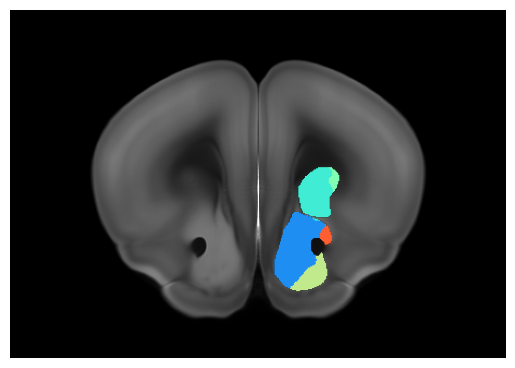

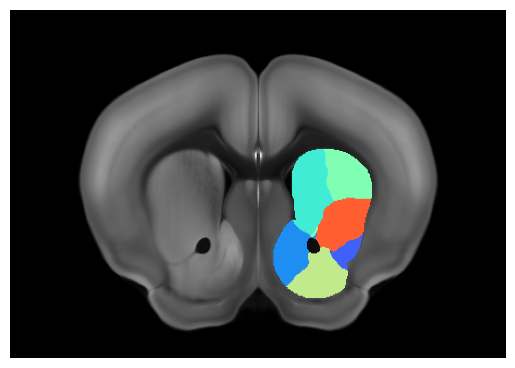

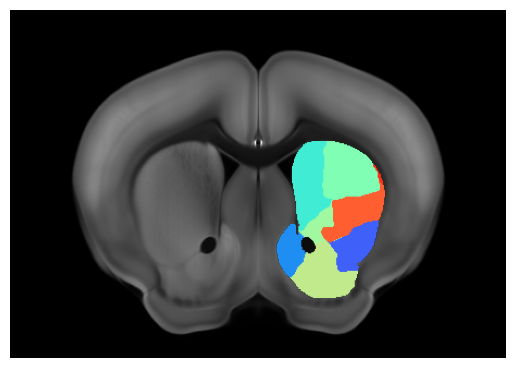

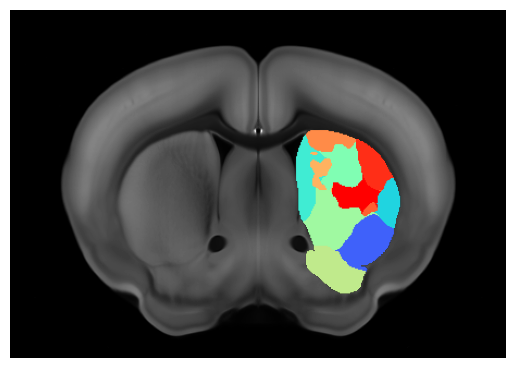

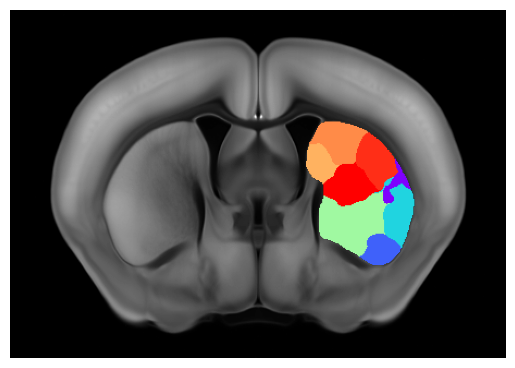

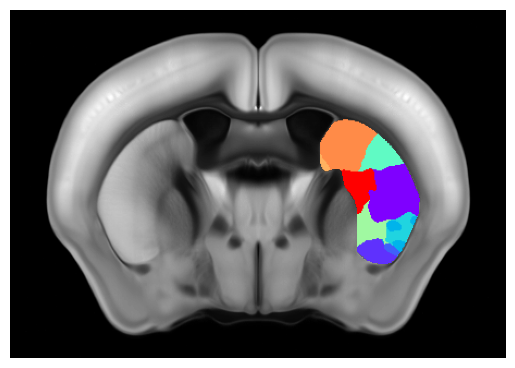

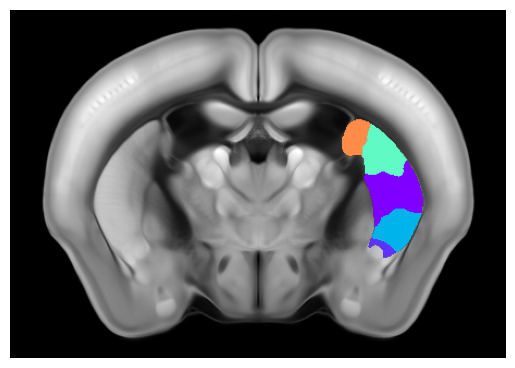

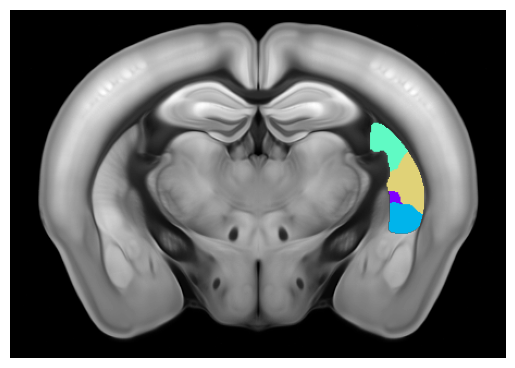

In [13]:
for i in slice_num:
    plt.figure()
    plt.imshow(template[0][:,:,int(i)].T,cmap='gray')
    plt.imshow(np.transpose(colorize_str[:,:,i],axes=[1,0,2]))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    out_path = '/Users/krystal/Desktop/project/microenvironment/figs/Fig3/STR/str_bg_'+str(int(i))+'.png'
    plt.savefig(out_path,dpi=100)
    # img.convert('RGB').save(out_path)

##### CP Yanjun

In [14]:
image = cv2.imread('/Users/krystal/Downloads/Composite.tif',cv2.IMREAD_UNCHANGED)
import SimpleITK as sitk
image = sitk.GetArrayFromImage(sitk.ReadImage('/Users/krystal/Downloads/Composite.tif'))

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


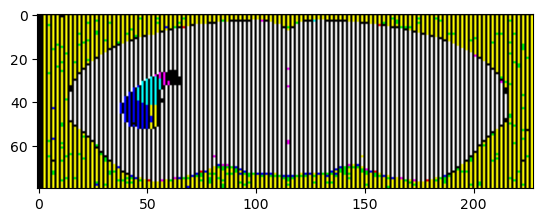

In [49]:
plt.imshow(np.transpose(image[:,:,66],axes=[1,0,2]),vmin=0,vmax=1)

In [15]:
delete_idx = []
retain_idx = []

for i in range(image.shape[0]):
    # tmpsum = image[i].sum()
    # if tmpsum!=0:
    #     delete_idx.append(i)
    # else:
    if np.sum(image[i].mean(axis=-1)==image[i][:,:,0])>=image[i].shape[0]*image[i].shape[1]*0.9:
        delete_idx.append(i)
    else:
        retain_idx.append(i)

# image = image[delete_idx1]
image_djt = image.copy()
image_djt[np.abs(image_djt.mean(axis=-1)-image_djt[:,:,:,0])>0.1]=[0,0,0]
for i in delete_idx:
    tmpslice = image[i].copy()
    tmpmask = tmpslice.mean(axis=-1)>0
    image_djt[i+1][tmpmask] = tmpslice[tmpmask]
image_djt = image_djt[retain_idx]


In [14]:
image_djt.shape

(113, 80, 132, 3)

In [13]:
slice_num2 =[4*i+38 for i in range(8)]

In [45]:
for i in slice_num2:
    plt.figure()
    #np.transpose(colorize_img[:,:,i],axes=[1,0,2])
    plt.imshow(np.transpose(image_djt[:,:,i],axes=[1,0,2]),vmin=0,vmax=1)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    out_path = '/Users/krystal/Desktop/project/microenvironment/figs/Fig3/STR/str_yj_'+str(int(i))+'.png'
    plt.savefig(out_path,dpi=100)
    # img.convert('RGB').save(out_path)

NameError: name 'slice_num2' is not defined

#### Comparison

In [16]:
save_image('str.nrrd', str_mask, useCompression=True)

True

In [17]:
str_stereo = load_image('stereo_img/STR.nrrd')
nzcoords = str_stereo.nonzero()
nzcoords_t = np.array(nzcoords).transpose()
colorize_str_stereo = random_colorize(nzcoords_t,str_stereo[nzcoords],str_stereo.shape,np.max(str_stereo))

In [24]:
np.max(str_stereo)

17

In [18]:
image_djt.shape,colorize_str_stereo.shape

((113, 80, 132, 3), (456, 302, 528, 4))

In [19]:
y_ratio = colorize_str_stereo.shape[1]/image_djt.shape[1]

In [39]:
### ours
zmin, ymin, xmin, = nzcoords_t.min(axis=0)
zmax, ymax, xmax = nzcoords_t.max(axis=0)
zmin, ymin, xmin,zmax, ymax, xmax

(242, 92, 154, 385, 252, 319)

In [27]:
image_ion_reduced = image_djt[:,:,:,0]
image_ion_flattened = image_ion_reduced.reshape(image_djt.shape[0],image_djt.shape[1],image_djt.shape[2])

In [30]:
nzcoords_lg = image_ion_flattened.nonzero()
nzcoords_lg_t = np.array(nzcoords_lg).transpose()
zmin_lg, ymin_lg, xmin_lg = nzcoords_lg_t.min(axis=0)
zmax_lg, ymax_lg, xmax_lg = nzcoords_lg_t.max(axis=0)
zmin_lg, ymin_lg, xmin_lg, zmax_lg, ymax_lg, xmax_lg

(5, 2, 1, 107, 78, 131)

In [20]:
import webcolors

In [21]:
count1 = 0
count2 = 0
color_dict1 = {}
color_dict2 = {}
pixel_class_matrix = np.zeros((25,9))
mismatch_cnt = 0
for i in range(colorize_str_stereo.shape[0]):
    for j in range(colorize_str_stereo.shape[1]):
        for k in range(colorize_str_stereo.shape[2]):
            c_value1 =  colorize_str_stereo[i,j,k]
            posz = 112-i//4
            posy = int(np.floor(j/y_ratio))
            posx = k//4
            if (posz+1 >= image_djt.shape[0]) or (posy+1 >= image_djt.shape[1]) or (posx+1 >= image_djt.shape[2]):
                continue
            c_value2 = image_djt[posz,posy,posx]
            if (np.array_equal(c_value1,[0,0,0,0])) or (np.array_equal(c_value2,[0., 0., 0.])):
                if ( ~np.array_equal(c_value1,[0,0,0,0]) and (np.array_equal(c_value2,[0., 0., 0.]))):
                    mismatch_cnt += 1
                continue
            if (int(c_value2[0]*255)==int(c_value2[1]*255)) and (int(c_value2[1]*255)==int(c_value2[2]*255)):
                mismatch_cnt += 1
                continue
            rgb_tuple1 = (c_value1[0],c_value1[1],c_value1[2])
            rgb_tuple2 = (int(c_value2[0]*255),int(c_value2[1]*255),int(c_value2[2]*255))
            hex1 = webcolors.rgb_to_hex(rgb_tuple1)
            hex2 = webcolors.rgb_to_hex(rgb_tuple2)
            if hex1 not in color_dict1:
                color_dict1[hex1] = count1
                count1 += 1
            if hex2 not in color_dict2:
                color_dict2[hex2] = count2
                count2 += 1
            
            pixel_class_matrix[color_dict1[hex1],color_dict2[hex2]] += 1

In [120]:
test1 = pixel_class_matrix.copy()

In [30]:
pixel_class_matrix2 = np.delete(pixel_class_matrix,np.arange(np.max(str_stereo),25,1),axis=0)

In [31]:
pixel_class_matrix_p = pixel_class_matrix2.copy()
for i in range(pixel_class_matrix2.shape[0]):
    if np.sum(pixel_class_matrix_p[i,:]) == 0:
        continue
    pixel_class_matrix_p[i,:] = pixel_class_matrix_p[i,:]/np.sum(pixel_class_matrix_p[i,:])

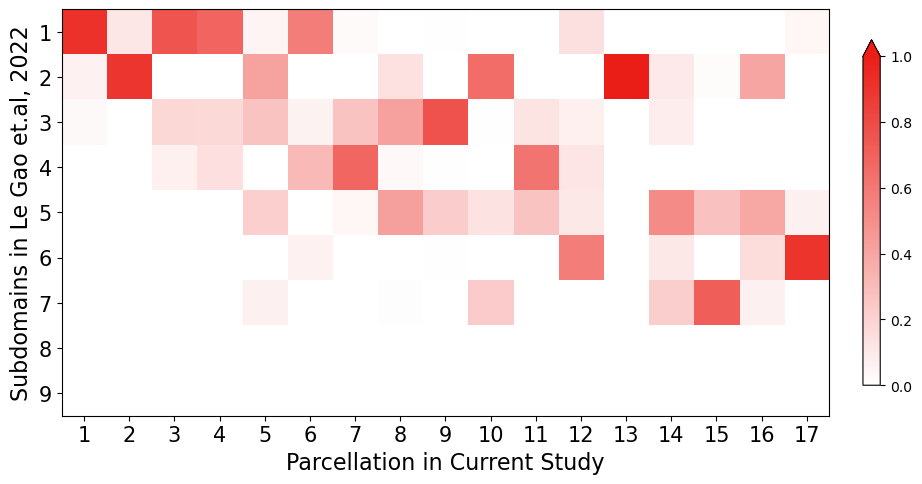

In [35]:
from matplotlib.colors import LinearSegmentedColormap
rmblist = ['#FFFFFF','#EB1E17']
rmbcmp = LinearSegmentedColormap.from_list("a",rmblist)
fig = plt.figure(figsize=(12,5))
plt.gcf().subplots_adjust(left=0.7,right=0.8,bottom=0.7,top=0.8)
# sns.heatmap(pixel_class_matrix_p.T,square=True,cmap = rmbcmp)
plt.imshow(pixel_class_matrix_p.T,cmap=rmbcmp,aspect=1)
plt.xticks(ticks=np.arange(0,17,1),labels=np.arange(1,18,1),fontsize=15)
plt.yticks(ticks=np.arange(0,9,1),labels=np.arange(1,10,1),fontsize=15)
plt.xlabel('Parcellation in Current Study',fontsize=16)
plt.ylabel('Subdomains in Le Gao et.al, 2022',fontsize=16)
plt.colorbar(pad=0.03,orientation='vertical',ticks=None,label=None,extend='max',shrink=0.85,location='right')
plt.tight_layout()
plt.savefig("/Users/krystal/Desktop/project/microenvironment/figs/Fig3/match_heatmap.png",dpi=100)

In [72]:
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [105]:
cmap = mpl.cm.rainbow_r
my_color = cmap(np.linspace(0,2,25))
my_color2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in my_color]
cmap2 = mpl.cm.Dark2
my_cr = cmap(np.linspace(0,1,9))
my_cr2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in my_cr]

In [104]:
parc_names = ['R'+str(i) for i in range(1,26)]
le_names = ['R'+str(i) for i in range(1,10)]
nodes = dict(label = parc_names+le_names,color=my_color2+my_cr2)
ss = []
ts = []
vs = []
cs = []
for i in range(pixel_class_matrix.shape[0]):
    for j in range(pixel_class_matrix.shape[1]):
        if pixel_class_matrix[i,j]>0:
            ss.append(i)
            ts.append(j+25)
            vs.append(pixel_class_matrix[i,j])
            color = my_color[i]
            color[3] = 0.7
            cs.append(mpl.colors.rgb2hex(color,keep_alpha=False))
links = dict(
    source = ss,
    target = ts,
    value = vs,
    color = cs
)
data = go.Sankey(node = nodes, link=links)
fig = go.Figure(data)
fig.show()
